In [37]:
print(1)


1


In [38]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score

import re
import numpy as np
import json
import os
from transformers import AutoTokenizer
import gensim

from results_config import *

In [39]:
import sys
sys.path.append("scripts/")
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import full_preproc, clean


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

In [40]:
s = load_sara()
processed_emails = [clean(a) for a in s.text]
ids = s.doc_id.tolist()
sens = s.sensitivity.tolist()
texts = [' '.join(processed_emails[i]) for i, text in enumerate(s.text)]
new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
s = pd.DataFrame.from_dict(new_dict)

#### Reading results

In [41]:
def get_join(doc_ids, preds, gts):
    clean_doc_ids = {}
    for i, idd in enumerate(doc_ids):
        if '_' in idd:
            idd = idd[:idd.find('_')]

        p = preds[i]
        gt = gts[i]
        if p is None:
            p = 1.0
        new_pred = {
            'doc_id': idd,
            'prediction': p,
            'ground_truth': gt,
        }
        if idd not in clean_doc_ids.keys():
            clean_doc_ids[idd] = new_pred
            continue
        if p == 0:
            continue
        clean_doc_ids[idd] = new_pred
    return clean_doc_ids

In [42]:
# Adopted from full_preproc
def no_reply_proc(s, tokenizer, c_size=2048):

    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df

    return main(s)

clean_unique_docs = no_reply_proc(load_sara(), '')

In [43]:
def new_get_join(data):
    collected_truths = []
    collected_docids = []
    mapp = {}
    for item in data:
        doc_id = item.get('doc_id')
        if '_' in doc_id:
            doc_id = doc_id[:doc_id.find('_')]
        truth = clean_unique_docs[clean_unique_docs.doc_id == doc_id].iloc[0].sensitivity
        pred = item.get('prediction')

        if doc_id not in collected_docids:
            if pred is None:
                pred = 1
            collected_docids.append(doc_id)
            collected_truths.append(truth)
            new_pred = {
                'doc_id': doc_id,
                'prediction': pred,
                'ground_truth': truth,
            }
            mapp[doc_id] = new_pred

        if pred == 1:
            new_pred = {
                'doc_id': doc_id,
                'prediction': int(pred),
                'ground_truth': int(truth),
            }
            mapp[doc_id] = new_pred

    mapp = list(mapp.values())
    return pd.DataFrame(mapp)

In [44]:
def get_results_json(mname, clean=True):
    current_directory = os.getcwd()
    #parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(current_directory, f'scripts/results/model_results/{mname}/')
    #print("Path to results", target_directory)
    prompt_results = os.listdir(target_directory)
    main_results = []
    prompts_and_answers = {
        'text': 'non-sensitive',
        'pdc2': 'non-personal',
        'cg': 'non-personal',
        'textfew': 'non-sensitive',
        'pdcfew': 'non-personal',
        'cgfew': 'non-personal',
        'hop1': 'non-personal'
    }
    prompts = list(prompts_and_answers.keys())
    for prompt in prompt_results:
        if prompt not in prompts:
            continue
        prompt_path = os.path.join(target_directory, prompt)
        file_path = os.path.join(prompt_path, 'all_responses.json')
        with open(file_path) as json_file:
            data = json.load(json_file)

        new_data = [] #{doc_id, prediction, ground_truth}
        negative = prompts_and_answers.get(prompt)
        for i, v in enumerate(data):
            idd = v.get('doc_id')
            gt = v.get('ground_truth')
            ans = v.get('generated_response')
            #ans = 'The text does contain sensitive'
            class_seg = ans[:25]
            if negative in ans:
                pred = 0
            else:
                pred = 1

            new_data.append({'doc_id': idd, 'prediction': pred, 'ground_truth': gt, 'model':mname, 'prompt': prompt, 'generated_response':ans})
        data = new_data

        if not clean:
            main_results += data
            continue

        data_df = new_get_join(data)
        clean_json = []
        for i, v in data_df.iterrows():
            clean = {
                'doc_id': v.doc_id,
                'prediction': v.prediction,
                'ground_truth': v.ground_truth,
                'model': mname,
                'prompt': prompt
            }
            clean_json.append(clean)

        main_results += clean_json
    df = pd.DataFrame(main_results)
    return df

In [45]:
all_results_df = get_results_json('mist-noreply')
gen_results_df = get_results_json('mist-noreply', clean=False)

In [12]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
11013,125762,0,0,mist-noreply,pdcfew
11014,234238,0,0,mist-noreply,pdcfew
11015,174214,0,0,mist-noreply,pdcfew
11016,175841,1,0,mist-noreply,pdcfew


In [12]:
#all_results_df[(all_results_df.prediction!=0) & (all_results_df.prediction!=1)]


#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [27]:
def calculate_accuracy(group, average_type='binary'):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group, average_type='binary'):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group, average_type='binary'):
    return f1_score(group['ground_truth'], group['prediction'], average=average_type)

def calc_prec(group, average_type='binary'):
    return precision_score(group['ground_truth'], group['prediction'], average=average_type)

def calc_rec(group, average_type='binary'):
    return recall_score(group['ground_truth'], group['prediction'], average=average_type)

def tpr(group, average_type='binary'):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tpr = tp / (tp+fn)
    return tpr

def tnr(group, average_type='binary'):
    tn, fp, fn, tp = confusion_matrix(group['ground_truth'], group['prediction']).ravel()
    tnr = tn / (tn+fp)
    return tnr

def calculate_f2(group, average_type='binary'):
    return fbeta_score(group['ground_truth'], group['prediction'], beta=2, average=average_type)

def auroc(group, average_type='binary'):
    return roc_auc_score(group['ground_truth'], group['prediction'])

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='Accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='BAC')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='$F_{1}$')
    prec_df = grouped.apply(calc_prec).reset_index(name='Precision')
    rec_df = grouped.apply(calc_rec).reset_index(name='Recall')
    tpr_df = grouped.apply(tpr).reset_index(name='TPR')
    tnr_df = grouped.apply(tnr).reset_index(name='TNR')
    f2_score_df = grouped.apply(calculate_f2).reset_index(name='$F_{2}$')
    auroc_df = grouped.apply(auroc).reset_index(name='auROC')

    # Merge results into a single DataFrame - easy comparison
    performance_df = accuracy_df
    performance_df = pd.merge(performance_df, prec_df, on=['model', 'prompt'])
    #performance_df = pd.merge(performance_df, rec_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tpr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, tnr_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f2_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, balanced_accuracy_df, on=['model', 'prompt'])
    #performance_df = pd.merge(performance_df, auroc_df, on=['model', 'prompt'])

    return performance_df

def round_df(df):
    for v in df.keys():
        if v == 'model' or v == 'prompt':
            if v == 'model':
                mname = df[v].iloc[0]
                if mname == 'mist-noreply' or mname=='mist7b-mist':
                    df[v] = df[v].apply(lambda x: 'Mistral')
                elif mname == 'mixt-noreply' or mname=='mixt-4bit':
                    df[v] = df[v].apply(lambda x: 'Mixtral')
                elif mname == 'l27b-noreply' or mname=='l27b-meta':
                    df[v] = df[v].apply(lambda x: 'Llama 2')
            continue
        df[v] = df[v].apply(lambda x: round(x, 4))
    return df

def get_prompt_performance():
    prompt_performance_df = prompt_performance(all_results_df)
    prompt_order = ['text', 'pdc', 'cg', 'textfew', 'pdcfew', 'cgfew', 'hop1']
    prompt_performance_df['prompt'] = pd.Categorical(prompt_performance_df['prompt'], categories=prompt_order, ordered=True)
    prompt_performance_df = prompt_performance_df.sort_values('prompt')
    prompt_performance_df = round_df(prompt_performance_df)
    return prompt_performance_df

prompt_performance_df = get_prompt_performance()

In [28]:
prompt_performance_df

,model,prompt,Accuracy,Precision,TPR,TNR,$F_{1}$,$F_{2}$,BAC
5,Mistral,text,0.6042,0.0806,0.2092,0.6604,0.1163,0.1585,0.4348
3,Mistral,pdc,0.4765,0.1587,0.7449,0.4383,0.2616,0.4284,0.5916
0,Mistral,cg,0.6449,0.2195,0.7245,0.6335,0.3369,0.4962,0.6790
6,Mistral,textfew,0.5966,0.1087,0.3112,0.6372,0.1612,0.2268,0.4742
4,Mistral,pdcfew,0.5534,0.1803,0.7296,0.5283,0.2892,0.4534,0.6289
1,Mistral,cgfew,0.6182,0.2069,0.7296,0.6023,0.3224,0.4847,0.6660
2,Mistral,hop1,0.6938,0.2082,0.5204,0.7184,0.2974,0.4003,0.6194


In [18]:
all_results_df = get_results_json('mist-noreply')
prompt_performance_df = prompt_performance(all_results_df)

### Document Difficultly

In [30]:
prompts = ['text', 'pdc2', 'cg', 'textfew', 'pdcfew', 'cgfew']

In [32]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

def get_all_wrong_docs():
    all_wrong = get_all_wrong()
    doc_ids = all_wrong.doc_id.to_list()
    filtered_df = s[s['doc_id'].isin(doc_ids)]
    return filtered_df

focused_df = all_results_df[all_results_df['prompt'].isin(prompts)]
most_difficult_docs = get_most_difficult_docs(focused_df)
all_wrong = get_all_wrong()
#all_wrong = most_difficult_docs[:100]
docs_all_wrong = get_all_wrong_docs()

In [33]:
sum(docs_all_wrong.sensitivity.to_list())

18

In [34]:
print(len(docs_all_wrong))
proc_wrong = full_preproc(docs_all_wrong, "mist-noreply")
print(len(proc_wrong))

68
mistralai/Mistral-7B-Instruct-v0.2
95


In [24]:
doc_lengths = s.text.str.len()
print(sorted(doc_lengths.values, reverse=True))

[207061, 190116, 190116, 171851, 171851, 169371, 169371, 151783, 151783, 151783, 131958, 131958, 127632, 127632, 127632, 127632, 127632, 127632, 113765, 113765, 112401, 112401, 110186, 110186, 110186, 110186, 110186, 110186, 110186, 104395, 104395, 104395, 104395, 104395, 100077, 100077, 100077, 90210, 90210, 90210, 85611, 85611, 81297, 78496, 78496, 78496, 78496, 78496, 67419, 67419, 67419, 67419, 67419, 62917, 62917, 62541, 61299, 61299, 59862, 59862, 59862, 59862, 59862, 56536, 51431, 45835, 43595, 39742, 31633, 31441, 30067, 30059, 29885, 28093, 27194, 23322, 21475, 21318, 21194, 20554, 20532, 20478, 20372, 20290, 20240, 20195, 15262, 14253, 14130, 13424, 13293, 13293, 13049, 12552, 12377, 12321, 12305, 11384, 11113, 11111, 10952, 10761, 10563, 10351, 10327, 10266, 10074, 9860, 9205, 9205, 8986, 8639, 8393, 8350, 8249, 8090, 8070, 8045, 7952, 7801, 7787, 7766, 7568, 7499, 7305, 7300, 7244, 7164, 7155, 7154, 7119, 7118, 7097, 7056, 6985, 6937, 6585, 6574, 6435, 6384, 6347, 6346, 628

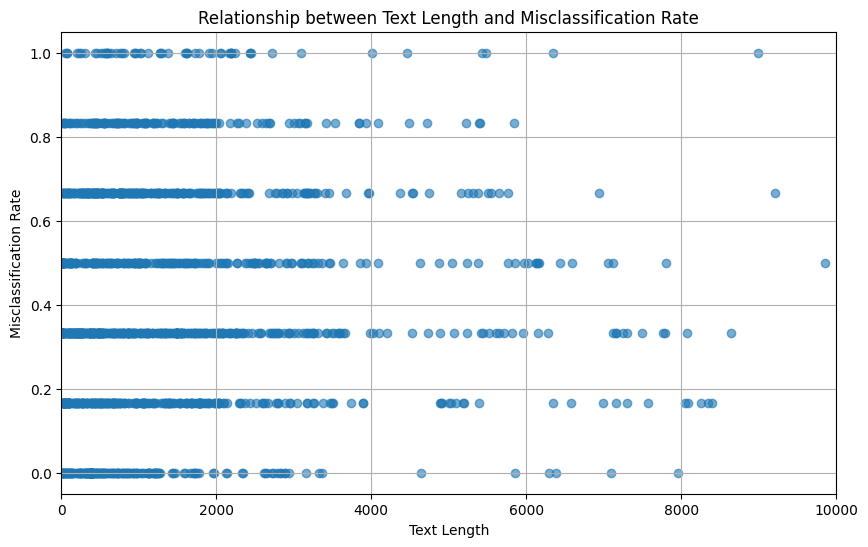

In [25]:
pdf = pd.merge(s, most_difficult_docs, on=['doc_id'])
pdf
df = pdf
df['text_length'] = df['text'].apply(len)

# Plotting the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['misclassification_rate'], alpha=0.6)
plt.title('Relationship between Text Length and Misclassification Rate')
plt.xlabel('Text Length')
plt.ylabel('Misclassification Rate')
plt.grid(True)
plt.xlim(0, 10000)
plt.show()

In [26]:
all_wrong_df = filtered_df
for i, v in all_wrong_df.iterrows():
    print('Document', v.doc_id, 'Class', v.sensitivity, 'Cat', hearst_genres.get(mapp.get(v.doc_id)))
    print(v.text)
    print()

NameError: name 'hearst_genres' is not defined

### Statistical Testing - McNemar

<Figure size 500x500 with 0 Axes>

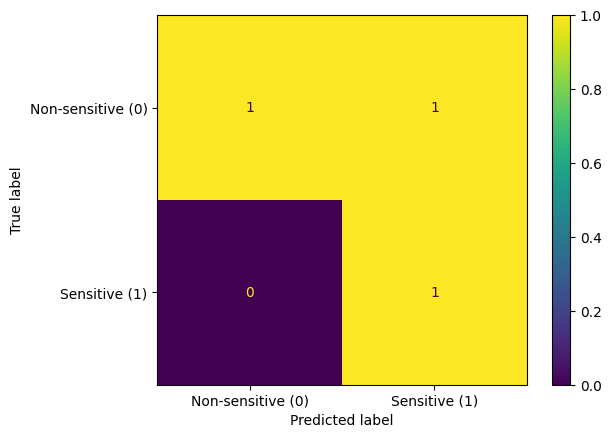

In [13]:
def evaluation_summary(true_labels, predictions):
    target_labels = [0, 1]
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    report = classification_report(true_labels, predictions, labels=target_labels, target_names=target_classes, digits=3, zero_division=0)
    #print(report)
    confusionMatrix = confusion_matrix(true_labels, predictions, labels=target_labels)
    fig = plt.figure(1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes)
    disp.plot()
    #disp.figure_.savefig(description+"confusion_matrix.pdf")
    plt.show()
    return disp

evaluation_summary([1,0,0], [1,0,1])

<Figure size 500x500 with 0 Axes>

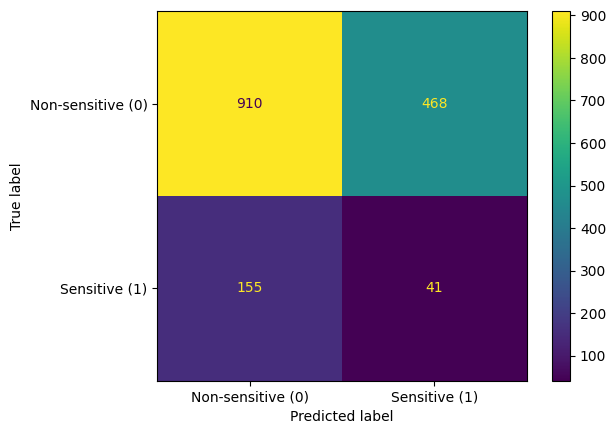

<Figure size 500x500 with 0 Axes>

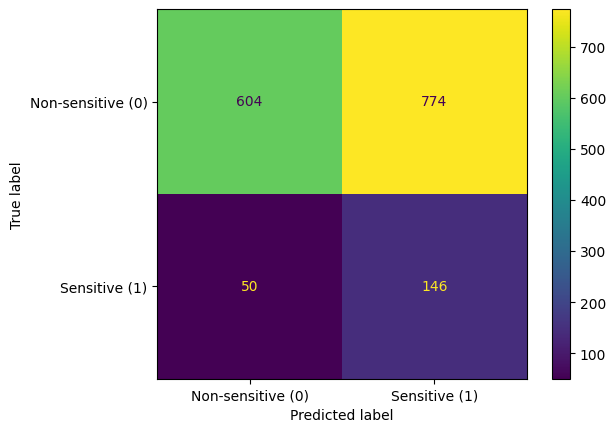

<Figure size 500x500 with 0 Axes>

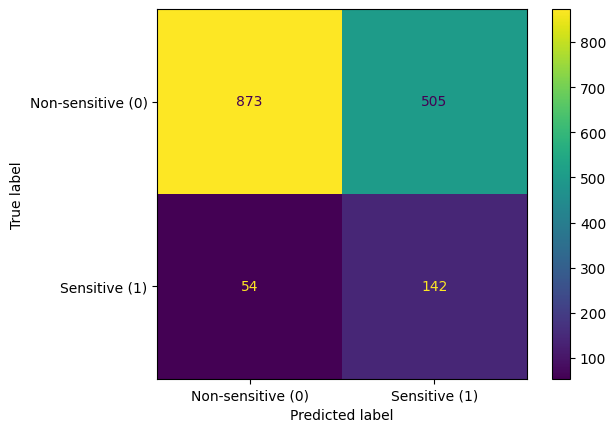

In [ ]:
p = all_results_df[all_results_df.prompt == 'text'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'text'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'pdc'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'pdc'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'cg'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'cg'].ground_truth.to_list()

evaluation_summary(t, p)

#p = all_results_df[all_results_df.prompt == 'itspersonalgenres'].prediction.to_list()
#t = all_results_df[all_results_df.prompt == 'itspersonalgenres'].ground_truth.to_list()
#evaluation_summary(t, p)


In [14]:
focused_df.prompt.unique()

NameError: name 'focused_df' is not defined

In [15]:
from statsmodels.stats.contingency_tables import mcnemar

# Example predictions
# Let's assume 0 for incorrect predictions and 1 for correct predictions
model1_predictions = [1, 0, 1, 1, 0, 1, 0, 1]
model2_predictions = [1, 1, 1, 0, 0, 0, 1, 0]

# Building the contingency table
contingency_table = [[0, 0], [0, 0]]

for pred1, pred2 in zip(model1_predictions, model2_predictions):
    contingency_table[pred1][pred2] += 1

contingency_table

[[1, 2], [3, 2]]

In [16]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if (model_name != model_name2) and (prompt_name != prompt_name2):
        print('Multiple difference')
        return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_prompt(non_results_df, prompt_name, prompt_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_prompt(sen_results_df, prompt_name, prompt_name2)
    else:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_model(non_results_df, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_model(sen_results_df, model_name, model_name2)

    print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table), end='')
    #print(np.matrix(non_table), end='')

    print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))
    return overall_table

'''
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('multi_category','cg'), ('base_personal', 'pdc')]
#compare = [('cg', 'cgfew')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)
    run_mcnemar(overall)
'''

'\nmodel_name = \'mist-noreply\'\nmodel_name2 = \'mist-noreply\'\n\ncompare = [(\'multi_category\',\'cg\'), (\'base_personal\', \'pdc\')]\n#compare = [(\'cg\', \'cgfew\')]\n\nfor v in compare:\n    print("""Mcnemar\'s where,\n                        Condition 2 Positive\t    Condition 2 Negative\nCondition 1 Positive\tA (Positive at both times)\tB (Positive then Negative)\nCondition 1 Negative\tC (Negative then Positive)\tD (Negative at both times)\n    """)\n    print(\'Control:\', v[0], \'\tChange:\', v[1])\n    prompt_name = v[0]\n    prompt_name2 = v[1]\n    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, all_results_df)\n    run_mcnemar(overall)\n'

In [19]:
focused_df = all_results_df[(all_results_df.prompt == 'cg') | (all_results_df.prompt == 'cgfew') | (all_results_df.prompt == 'hop1')]

In [20]:
focused_df.prompt.unique()

array(['cgfew', 'cg', 'hop1'], dtype=object)

In [21]:
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), 
           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]
compare = [('cg', 'cgfew'), ('cg', 'hop1'), ('cgfew', 'hop1')]

for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    run_mcnemar(overall)

Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: cg 	Change: cgfew
Overall		 Non-sensitive only	 Sensitive only
[[843 172]] 	 [[713 160]] 		 [[130  12]]
[[130 429]] 	 [[117 388]] 		 [[13 41]]
statistic=130.000, p-value=1.8163E-02
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: cg 	Change: hop1
Overall		 Non-sensitive only	 Sensitive only
[[761 254]] 	 [[672 201]] 		 [[89 53]]
[[331 228]] 	 [[318 187]] 		 [[13 41]]
statistic=254.000, p-value=1.6540E-03
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 

In [45]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    return result.statistic, result.pvalue
    print('statistic=%.3f, p-value=%.4E' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_both(results_df, p1, p2, m1, m2):
    orig = results_df[(results_df.model == model_name) & (results_df.prompt==p1)]
    pure = results_df[(results_df.model == model_name2) & (results_df.prompt==p2)]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    #if (model_name != model_name2) and (prompt_name != prompt_name2):
    #    print('Multiple difference')
    #    return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_prompt(non_results_df, prompt_name, prompt_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_prompt(sen_results_df, prompt_name, prompt_name2)
    elif model_name != model_name2:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_model(non_results_df, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_model(sen_results_df, model_name, model_name2)
    else:
        results_df = df[(df.model == model_name) | (df.model == model_name2)]
        overall_table = mc_eval_util_both(results_df, prompt_name, prompt_name2, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_both(non_results_df, prompt_name, prompt_name2, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_both(sen_results_df, prompt_name, prompt_name2, model_name, model_name2)
    print(sen_table)
    print(non_table)


    return overall_table

'''
model_name = 'mist-noreply'
model_name2 = 'mist-noreply'

compare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), 
           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]
#compare = [('cg', 'cgfew')]

stat_tests = []
for v in compare:
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    stat, p = run_mcnemar(overall)
    stat_tests.append({'model':model_name, 'original': v[0], 'change': v[1], 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.05)})
stat_tests = pd.DataFrame.from_dict(stat_tests)
print(stat_tests)
'''

"\nmodel_name = 'mist-noreply'\nmodel_name2 = 'mist-noreply'\n\ncompare = [('text','pdc'), ('text', 'cg'), ('pdc', 'cg'), \n           ('text', 'textfew'), ('pdc','pdcfew'), ('cg','cgfew')]\n#compare = [('cg', 'cgfew')]\n\nstat_tests = []\nfor v in compare:\n    print('Control:', v[0], '\tChange:', v[1])\n    prompt_name = v[0]\n    prompt_name2 = v[1]\n    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)\n    stat, p = run_mcnemar(overall)\n    stat_tests.append({'model':model_name, 'original': v[0], 'change': v[1], 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.05)})\nstat_tests = pd.DataFrame.from_dict(stat_tests)\nprint(stat_tests)\n"

In [34]:
focused_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
9439,125762,0,0,mist-noreply,pdcfew
9440,234238,0,0,mist-noreply,pdcfew
9441,174214,0,0,mist-noreply,pdcfew
9442,175841,1,0,mist-noreply,pdcfew


In [35]:
mistall_results_df = get_results_json('mist-noreply')
l2all_results_df = get_results_json('l27b-noreply')

df = pd.concat([mistall_results_df, l2all_results_df])


In [36]:
mixtall_results_df = get_results_json('mixt-noreply')
flanall_results_df = get_results_json('flanxl-noreply')

df = pd.concat([df, mixtall_results_df])
df = pd.concat([df, flanall_results_df])

In [48]:
model_name = 'mist-noreply'
model_name2 = 'mixt-noreply'

compare = [('text','text'), ('pdc', 'pdc'), ('cg', 'cg'), 
           ('textfew','textfew'), ('pdcfew','pdcfew'), ('cgfew', 'cgfew')]
compare = [('cg', 'cgfew')]

stat_tests = []
for v in compare:
    print('Control:', model_name, '\tChange:', model_name2)
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df)
    print(overall)
    stat, p = run_mcnemar(overall)
    stat_tests.append({'prompt':v[0], 'original': model_name, 'change': model_name2, 'statistic':stat, 'p-value':('%.2E' % p), 'significant':(p < 0.05)})
stat_tests = pd.DataFrame.from_dict(stat_tests)
print(stat_tests)

Control: mist-noreply 	Change: mixt-noreply
[[130, 12], [13, 41]]
[[713, 160], [117, 388]]
[[843, 172], [130, 429]]
  prompt      original        change  statistic   p-value  significant
0     cg  mist-noreply  mixt-noreply      130.0  1.82E-02         True


In [ ]:
196/1300

0.15076923076923077

In [ ]:
overall

[[809, 164], [442, 159]]

### Document Comparison

In [22]:
import glob
email_files = [f.replace('.cats', '') for f in glob.glob('./*/*/*.cats')]
mapp = {}
for v in email_files:
    v = v.split('/')
    mapp[v[-1]] = v[-2]

hearst_genres = {
    '1': 'Company Business, Strategy',
    '2': 'Purely Personal',
    '3': 'Personal but in professional context',
    '4': 'Logistic Arrangements (meeting scheduling, technical support)',
    '5': 'Employment arrangements (job seeking, hiring, recommendations)', 
    '6': 'Document editing/checking (collaboration)', 
    '7': 'Empty message (due to missing attachment)', 
    '8': 'Empty message'
}

In [62]:
# Eval config
all_results_df = get_results_json('flanxl-noreply', clean=False)
#all_results_df = all_results_df[all_results_df.prompt == 'cg']


model_name = 'flanxl-noreply'
prompt_name_control = 'pdc'
prompt_name_change = 'cg'
truth_lab = 1
model_guess = 1

rdf = all_results_df
rdf_truth_select = rdf[rdf.ground_truth == truth_lab]
df = rdf_truth_select[(rdf_truth_select.model == model_name) & ((rdf_truth_select.prompt == prompt_name_control) |  (rdf_truth_select.prompt == prompt_name_change))]
guess_df = df[df.prediction == model_guess] #.doc_id.to_list()
diff_guess_df = guess_df.groupby('doc_id').filter(lambda x: x['prompt'].nunique() == 1)
id_diff_guesses = diff_guess_df.doc_id.to_list()

current_directory = os.getcwd()
file_path = os.path.join(current_directory, f'scripts/results/model_results/{model_name}/{prompt_name_control}/all_responses.json')
#print("Path to results", file_path)

genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]
s = load_sara()
filtered_df = s[s['doc_id'].isin(id_diff_guesses)]
# use map for tokenizer
filtered_df = full_preproc(filtered_df, tokenizer)

sum = 0
for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
    pred_control = control_row.prediction.iloc[0]
    gen_control = control_row.generated_response.iloc[0]
    change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
    pred_change = change_row.prediction.iloc[0]
    gen_change = change_row.generated_response.iloc[0]

    # Only show agreement/disagreement documents
    #if gen_pred_change == truth_lab:
    #if pred_change == pred_control:
    #    print(1)
    #    continue
    if pred_change == 0 or pred_control == 0:
        continue

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(mapp.get(idd)), '\nMessage:')
    print(text)
    print(s[s.doc_id == idd].iloc[0].text)
    print('End Message.')
    print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
    print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
    #print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 4:
    #    break


AttributeError: 'Series' object has no attribute 'text'

In [61]:
# Eval config
all_results_df = get_results_json('mist-noreply', clean=False)
#all_results_df = all_results_df[all_results_df.prompt == 'cg']

model_name = 'mist-noreply'
prompt_name_control = 'pdc'
prompt_name_change = 'cg'
truth_lab = 1
model_guess_control = 1
model_guess_change = 1


genx = all_results_df[(all_results_df.model == model_name) & ((all_results_df.prompt == prompt_name_control) | (all_results_df.prompt == prompt_name_change) )]
#s = load_sara()
#filtered_df = s
# use map for tokenizer
#filtered_df = full_preproc(filtered_df, tokenizer)

#print(len(filtered_df))
#sum = 0


In [77]:

for i, tex in enumerate(filtered_df.iterrows()):
    idd = tex[1].doc_id
    text = tex[1].text
    sens = tex[1].sensitivity
    control_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_control)]
    pred_control = control_row.prediction.iloc[0]
    gen_control = control_row.generated_response.iloc[0]
    change_row = genx[(genx.doc_id == idd) & (genx.prompt==prompt_name_change)]
    pred_change = change_row.prediction.iloc[0]
    gen_change = change_row.generated_response.iloc[0]

    # Only show agreement/disagreement documents
    #if gen_pred_change == truth_lab:
    #if pred_change == pred_control:
    #    print(1)
    #    continue
    clean_idd = idd
    if '_' in clean_idd:
        clean_idd = clean_idd[:idd.find('_')]

    genre = mapp.get(clean_idd)
    #if genre != '5':
    #    continue

    if 'you' not in text:
        continue
    if (pred_control == truth_lab or pred_change != truth_lab) or sens != truth_lab:
        continue

    print('DOCUMENT VIEW')
    print('Document', idd, 'Class', sens, 'Hearst cat', hearst_genres.get(mapp.get(clean_idd)), '\nMessage:')
    print(text)
    #print(s[s.doc_id == idd].iloc[0].text)
    print('End Message.')
    print(f'\nCONTROL {prompt_name_control}: Prediction:', pred_control, '. Response:', gen_control)
    print(f'\nCHANGE {prompt_name_change}: Prediction:', pred_change, '. Response:', gen_change)
    #print('Verbose desc:', verb)
    print('\n\n')
    
    #if i == 4:
    #    break


IndexError: single positional indexer is out-of-bounds

In [37]:
sum_chars = 0
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if '.jpg' in t:
        sum_chars += 1
        print(hearst_genres.get(mapp.get(idd)))
        print(t)
        #print()

print(sum_chars)




Company Business, Strategy
Message-ID: <1053178.1075847628125.JavaMail.evans@thyme>
Date: Wed, 28 Feb 2001 06:27:00 -0800 (PST)
From: steven.kean@enron.com
To: sean.long@enron.com
Subject: Nigeria Contract support
Cc: sherri.sera@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
Bcc: sherri.sera@enron.com
X-From: Steven J Kean
X-To: Sean Long
X-cc: Sherri Sera
X-bcc: 
X-Folder: \Steven_Kean_June2001_1\Notes Folders\All documents
X-Origin: KEAN-S
X-FileName: skean.nsf

Sean - is this anything we need to follow up on?
----- Forwarded by Steven J Kean/NA/Enron on 02/28/2001 02:26 PM -----

	Sherri Sera
	02/28/2001 01:58 PM
		 
		 To: Mark Frevert/NA/Enron, Steven J Kean/NA/Enron@Enron
		 cc: Nicki Daw/NA/Enron, Maureen McVicker/NA/Enron@Enron
		 Subject: Nigeria Contract support

Mark and Steve, sorry to bother you with this, but I'm at a loss.  This guy 
(Jim Cofield) called me on my cell phone last night about 7:00 p.m. to get m

In [38]:
sum_chars = 0
sin = [0] * 8
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if ' he ' in t or ' she ' in t:
        sum_chars += 1
        sin[(int(mapp.get(idd))-1)] += 1
        #print(t)
        #print()

print(sum_chars)
print(sin)

396
[258, 11, 25, 60, 32, 8, 0, 2]


In [74]:
sum_chars = 0
sin = [0] * 8
for i, samp in s.iterrows():
    t = samp.text
    idd = samp.doc_id
    if ' you' in t:
        sum_chars += 1
        sin[(int(mapp.get(idd))-1)] += 1
        #print(t)
        #print()

print(sum_chars)
print(sin)

1175
[603, 29, 79, 287, 66, 102, 2, 7]


### Persons

In [50]:
from pipeline import clean_names

def count_person(text):
    return text.count('<PERSON>')

def document_person_count(prompt):
    prompt_df = all_results_df[all_results_df.prompt == prompt]
    doc_ids = prompt_df.doc_id.to_list()
    s = load_sara()
    filtered_df = s[s['doc_id'].isin(doc_ids)].reset_index(drop=True)
    nonames_df = clean_names(filtered_df, replaced='<PERSON>')

    nonames_df['person_count'] = nonames_df['text'].apply(count_person)
    id_to_person_count = nonames_df.set_index('doc_id')['person_count'].to_dict()
    df_merged = pd.merge(prompt_df, nonames_df, on='doc_id')
    return df_merged



In [51]:
df_merged = document_person_count('cg')

In [52]:
df_merged

,doc_id,prediction,ground_truth,model,prompt,text,sensitivity,person_count
0,173164,1,0,mist-noreply,cg,Message-ID: <24200696.1075846140728.JavaMail.e...,0,2
1,162684,0,0,mist-noreply,cg,Message-ID: <21239198.1075852339402.JavaMail.e...,0,5
2,174260,1,0,mist-noreply,cg,Message-ID: <18822002.1075846172603.JavaMail.e...,0,3
3,121748,0,1,mist-noreply,cg,Message-ID: <26937321.1075843427227.JavaMail.e...,1,2
4,176657,0,0,mist-noreply,cg,Message-ID: <31804067.1075849874410.JavaMail.e...,0,2
...,...,...,...,...,...,...,...,...
1569,125762,0,0,mist-noreply,cg,Message-ID: <26285829.1075843673979.JavaMail.e...,0,1176
1570,234238,0,0,mist-noreply,cg,Message-ID: <22064966.1075860515772.JavaMail.e...,0,53
1571,174214,0,0,mist-noreply,cg,Message-ID: <1712069.1075846171358.JavaMail.ev...,0,27
1572,175841,0,0,mist-noreply,cg,Message-ID: <29023172.1075847627587.JavaMail.e...,0,153


In [53]:
def get_name_count_preds(pr, gt):
    xx = df_merged[(df_merged.prediction == pr) & (df_merged.ground_truth == gt)].person_count.to_list()
    return sum(xx) / len(xx)

tp_count = get_name_count_preds(1, 1)
tn_count = get_name_count_preds(0, 0)
fp_count = get_name_count_preds(1, 0)
fn_count = get_name_count_preds(0, 1)

print(tp_count)
print(tn_count)
print(fp_count)
print(fn_count)




18.802816901408452
44.38602520045819
40.83366336633664
18.703703703703702


In [ ]:
6.014084507042254
19.95876288659794
22.31089108910891
7.962962962962963

### Word distributions

In [ ]:
def word_distribution(prompt, tokenizer):
    prompt_df = all_results_df[all_results_df.prompt == prompt]
    proc = full_preproc(s, tokenizer)

    misclassified = prompt_df[prompt_df.prediction != prompt_df.ground_truth].doc_id.to_list()
    x = proc[proc['doc_id'].isin(misclassified)]

In [ ]:
misclassified = cg_df[cg_df.prediction != cg_df.ground_truth].doc_id.to_list()
x = proc[proc['doc_id'].isin(misclassified)]

In [ ]:
x

,doc_id,text,sensitivity
0,114715,though i had a somewhat different notion when ...,0
1,229405,fyi the attached article and story is disturbi...,0
2,232795,forwarded by richard b sanders hou ect on am s...,0
3,62815,louise lisa yoho suggested i forward the attac...,0
10,98429,you may have seen this when it first came out ...,0
...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0
1855,136394,original message from black andy sent friday s...,0
1858,176624,testing,0
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0


In [ ]:
x

,doc_id,text,sensitivity,tokens
0,114715,though i had a somewhat different notion when ...,0,"[somewhat, different, notion, initially, raise..."
1,229405,fyi the attached article and story is disturbi...,0,"[fyi, attached, article, story, disturbing, su..."
2,232795,forwarded by richard b sanders hou ect on am s...,0,"[forwarded, richard, b, sanders, hou, ect, ste..."
3,62815,louise lisa yoho suggested i forward the attac...,0,"[louise, lisa, yoho, suggested, forward, attac..."
10,98429,you may have seen this when it first came out ...,0,"[seen, came, worth, rerun, forwarded, steven, ..."
...,...,...,...,...
1854,115905,thanks whats a beep jeff dasovich sent by jeff...,0,"[thanks, s, beep, jeff, dasovich, sent, jeff, ..."
1855,136394,original message from black andy sent friday s...,0,"[original, message, black, andy, sent, friday,..."
1858,176624,testing,0,[testing]
1862,173252,fyi forwarded by steven j kean hou ees on pm j...,0,"[fyi, forwarded, steven, j, kean, hou, ees, pm..."


In [ ]:
s = clean_names(load_sara(), replaced='')

In [ ]:
proc = full_preproc(s, tokenizer)

In [ ]:
import spacy
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_sm")
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
stop_words_extra = ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come']
for word in stop_words_extra:
    nlp.vocab[word].is_stop = True


def get_most_counts(n):

    def remove_stop(text):
        doc = nlp(text)
        #doc = text.split()
        #print(doc)
        tokens = [t.text for t in doc if not t.is_stop] #not in stop_words]
        #bigrams = [tokens[i] + ' ' + tokens[i+1] for i in range(len(tokens)-1)]
        #tokens=bigrams
        #print(tokens)
        return tokens
    
    misclassified = cg_df[(cg_df.prediction == cg_df.ground_truth) & (cg_df.ground_truth == 1)].doc_id.to_list()

    x = proc[proc['doc_id'].isin(misclassified)]
    #print(x)

    x['tokens'] = x['text'].apply(remove_stop)

    all_ts = [token for sublist in x['tokens'] for token in sublist]
    from collections import Counter

    #token_counts = Counter([token for sublist in x['tokens'] for token in sublist])
    token_counts = Counter(all_ts)
    print(token_counts.most_common(n))


In [ ]:
get_most_counts(50)

[('message', 133), ('pm', 130), ('sent', 113), ('original', 101), ('cc', 100), ('june', 99), ('enron', 98), ('thanks', 74), ('nt', 71), ('e', 70), ('s', 68), ('mail', 63), ('kaminski', 63), ('m', 52), ('houston', 49), ('time', 48), ('j', 48), ('tuesday', 48), ('new', 47), ('july', 46), ('like', 44), ('com', 43), ('d', 41), ('work', 41), ('week', 40), ('great', 39), ('london', 39), ('forwarded', 38), ('hope', 38), ('business', 35), ('let', 34), ('office', 33), ('meeting', 32), ('going', 32), ('help', 30), ('fax', 28), ('job', 27), ('friday', 27), ('ve', 27), ('day', 26), ('best', 26), ('phone', 26), ('file', 26), ('hp', 25), ('forward', 25), ('conference', 25), ('energy', 24), ('information', 23), ('www', 23), ('group', 23)]


/tmp/ipykernel_434/3223568174.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
get_most_counts(20)

[('d d', 382), ('pm cc', 344), ('e mail', 283), ('enron pm', 246), ('forwarded enron', 223), ('original message', 210), ('pm pm', 144), ('natural gas', 113), ('market power', 101), ('expense report', 98), ('mail e', 95), ('usl usl', 94), ('california power', 86), ('power exchange', 86), ('confidential information', 83), ('px credit', 83), ('pg e', 81), ('message sent', 72), ('san diego', 70), ('corp enron', 70)]


/tmp/ipykernel_434/3668247273.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['tokens'] = x['text'].apply(remove_stop)


In [ ]:
misclassified = cg_df[(cg_df.prediction != cg_df.ground_truth) & (cg_df.ground_truth == 0)].doc_id.to_list()


In [23]:
### Mistral CG

In [24]:
focused_df

,doc_id,prediction,ground_truth,model,prompt
0,173164,1,0,mist-noreply,cgfew
1,162684,1,0,mist-noreply,cgfew
2,174260,1,0,mist-noreply,cgfew
3,121748,1,1,mist-noreply,cgfew
4,176657,1,0,mist-noreply,cgfew
...,...,...,...,...,...
9439,174465,1,0,mist-noreply,hop1
9440,174511,1,0,mist-noreply,hop1
9441,175448,0,0,mist-noreply,hop1
9442,175816,0,0,mist-noreply,hop1


In [25]:
unids = focused_df.doc_id.unique()
print(len(unids))

1574


In [42]:
def get_prompt(df, name):
    return df[df.prompt == name]

def get_pred_truth(df):
    p = df.prediction.iloc[0]
    t = df.ground_truth.iloc[0]
    return p, t

sm = 0
for idd in unids:
    sett = focused_df[focused_df.doc_id == idd]
    cg = get_prompt(sett, 'cg')
    cgfew = get_prompt(sett, 'cgfew')
    cghop = get_prompt(sett, 'hop1')
    cgp, cgt = get_pred_truth(cg)
    cgfp, _ = get_pred_truth(cgfew)
    cghp, _ = get_pred_truth(cghop)

    if cgt == 0:
        continue

    if cgp == cgfp:
        continue

    if cghp == 0:
        continue

    sm += 1


print(sm)

9
